In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from statsmodels.tsa.seasonal import seasonal_decompose
from tqdm import tqdm, tqdm_notebook
import time
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Restore defaults
# np.set_printoptions(edgeitems=3,infstr='inf', linewidth=75, nanstr='nan', precision=8,
#                     suppress=False, threshold=1000, formatter=None)

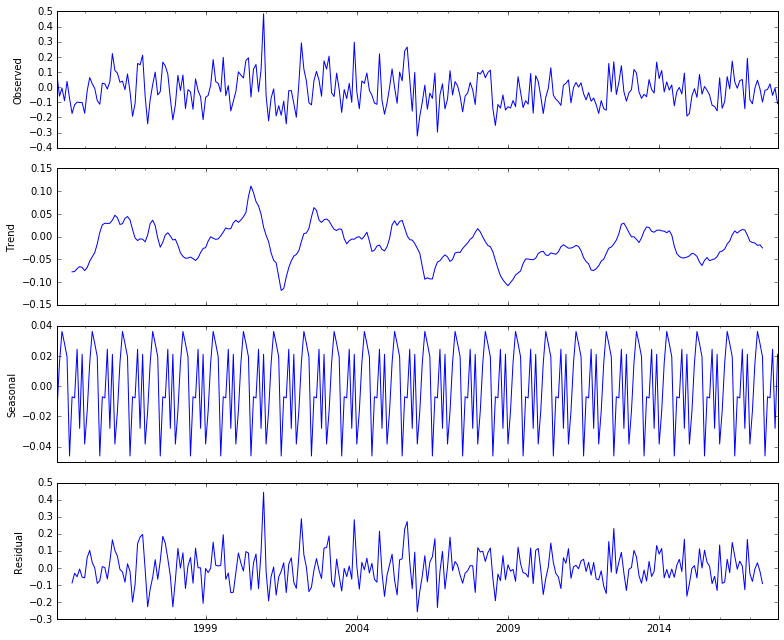

In [27]:
ticker = "UGAZ"

tk_dict = {
    "UGAZ":  ["UGAZ.xlsx",    3, 0.0165], # nat gas
    "UWTIF": ["SPGSCLP.xlsx", 3, 0.0135], # oil
    "UGLD":  ["SPGSGCP.xlsx", 3, 0.0135], # gold
    "UVXY":  ["SPVXSP.xlsx",  2, 0.0095], # VIX futures
}

df = pd.read_excel(tk_dict[ticker][0])
arr = np.array(df.pct_change()[1:])
arr = arr.reshape(-1,)

df_pct = df.pct_change()[1:]
df_monthly = df.resample("M", convention="end").mean()
df_mpct = df_monthly.pct_change()
df_mpct = df_mpct[1:]

seas_res = seasonal_decompose(df_mpct, model="additive")
rcParams["figure.figsize"] = 11, 9
fig = seas_res.plot()

In [28]:
avg_arr = np.zeros([12, 4])
avg_arr[:, 0] = np.arange(1, 12+1)
for i in range(1, 12+1):
    avg_arr[i-1, 1] = df_mpct[df_mpct.index.month == i].mean()
    avg_arr[i-1, 2] = df_mpct[df_mpct.index.month == i].std()
    avg_arr[i-1, 3] = ss.skew(df_mpct[df_mpct.index.month == i])

pd.DataFrame(index=avg_arr[:, 0], data=avg_arr[:, 1:],
             columns=("Mean", "Std", "Skew")).applymap(lambda x: "{0:,.3f}".format(x))

,Mean,Std,Skew
1.0,-0.057,0.112,-0.281
2.0,-0.030,0.120,0.009
3.0,-0.005,0.102,0.919
4.0,0.018,0.075,-0.367
5.0,0.007,0.094,-0.284
6.0,0.004,0.088,0.639
7.0,-0.061,0.078,0.779
8.0,-0.025,0.121,0.440
9.0,-0.024,0.124,0.064
10.0,0.003,0.092,0.505


In [29]:
mu = np.exp(np.sum(np.log(1+arr)))**(252/len(arr))-1
print("Mean historical annual return of underlying index: {0:,.1%}".format(mu))

Mean historical annual return of underlying index: -25.2%


In [30]:
sigma = np.sqrt(252/len(arr)*np.sum(np.log(1+arr)**2))*100
print("Historical realized volatility of underlying index: {0:,.1f}".format(sigma))

Historical realized volatility of underlying index: 48.4


In [31]:
days = 252
leverage = tk_dict[ticker][1]
fee = tk_dict[ticker][2]
trials = 10**4

Mean: -0.00068895
Median: -0.00088534
Skewness: 0.20964493
Kurtosis: 2.36504857


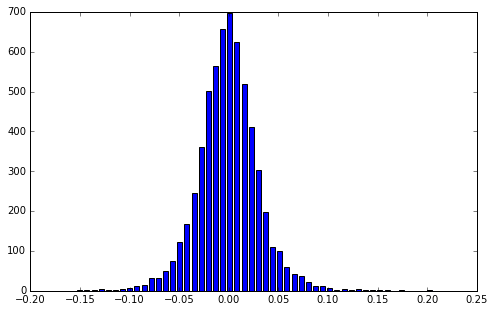

In [32]:
rcParams["figure.figsize"] = 8, 5
hist, bins = np.histogram(arr, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

print("Mean: {0:,.8f}".format(arr.mean()))
print("Median: {0:,.8f}".format(np.median(arr)))
print("Skewness: {0:,.8f}".format(ss.skew(arr)))
print("Kurtosis: {0:,.8f}".format(ss.kurtosis(arr, fisher=True)))

Mean: -0.00069104
Median: -0.00098220
Skewness: 0.19741290
Kurtosis: 2.20287376

10,000 trials
Runtime: 0.457 seconds


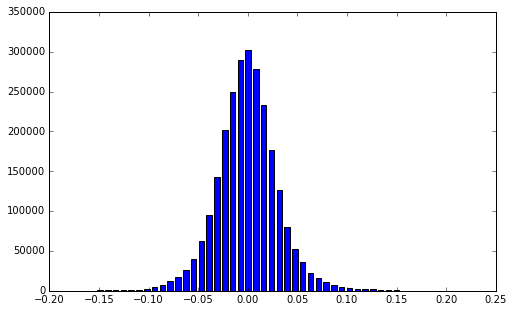

In [33]:
t1 = time.time()
kde_arr = ss.gaussian_kde(arr).resample(trials*days)
kde_arr = kde_arr.reshape(-1,)

hist, bins = np.histogram(kde_arr, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

print("Mean: {0:,.8f}".format(kde_arr.mean()))
print("Median: {0:,.8f}".format(np.median(kde_arr)))
print("Skewness: {0:,.8f}".format(ss.skew(kde_arr)))
print("Kurtosis: {0:,.8f}".format(ss.kurtosis(kde_arr, fisher=True)))
print("")
print("{0:,.0f}".format(trials), "trials")
print("Runtime: {:.3}".format(time.time()-t1), "seconds")

In [34]:
t1 = time.time()
a = np.zeros([trials, days, 3])

a[:, :, 0] = kde_arr.reshape(trials, days)          # Daily return of underlying using kernel density estimate
a[:, :, 1] = a[:, :, 0]*leverage - fee/252          # Leveraged daily return
a[:, :, 2] = np.cumprod(1+a[:, :, 1], axis=1)-1     # Cumulative percentage return
b = a[:, -1, 2]                                     # Array of period-end cumulative returns
c = np.max(a[:, :, 2], axis=1)                      # Array of rolling maximum cumulative spikes
print("{0:,.0f}".format(trials), "trials")
print("Runtime: {:.3}".format(time.time()-t1), "seconds")

10,000 trials
Runtime: 0.0923 seconds


In [35]:
t1 = time.time()
pctiles = [10, 25, 75, 90]

print("Annual returns:")
print("Mean: {:.1%}".format(b.mean()))
print("Median: {:.1%}".format(np.median(b)))

for pct in pctiles:
    print(str(pct)+"th %ile: {:.1%}".format(np.percentile(b, pct)))

print("0% return %ile:", "{:.3}".format(ss.percentileofscore(b, 0)))
print("")
print("Max Cumulative Spike:")
print("Mean: {:.1%}".format(c.mean()))
print("Median: {:.1%}".format(np.median(c)))

for pct in pctiles:
    print(str(pct)+"th %ile: {:.1%}".format(np.percentile(c, pct)))

print("100% spike %ile:", "{:.3}".format(ss.percentileofscore(c, 1.00)))
print("Runtime: {0:,.5f}".format(time.time()-t1), "seconds")

Annual returns:
Mean: -40.9%
Median: -80.4%
10th %ile: -97.1%
25th %ile: -92.9%
75th %ile: -47.3%
90th %ile: 27.7%
0% return %ile: 86.7

Max Cumulative Spike:
Mean: 109.6%
Median: 44.7%
10th %ile: 0.0%
25th %ile: 12.5%
75th %ile: 115.4%
90th %ile: 259.3%
100% spike %ile: 71.6
Runtime: 0.01227 seconds


In [36]:
arr_start = 0
arr_stride = 5
arr_end = arr_start + arr_stride

np.set_printoptions(precision=0)
np.set_printoptions(suppress=True)

In [37]:
arr_start += arr_stride
arr_end += arr_stride
a[arr_start:arr_end, 21*12-5:21*12, :]*10000

array([[[    292.,     876.,  210817.],
        [     15.,      43.,  211774.],
        [    132.,     397.,  220574.],
        [    224.,     672.,  236078.],
        [    -55.,    -164.,  232037.]],

       [[    129.,     386.,   -8908.],
        [    237.,     709.,   -8830.],
        [    524.,    1570.,   -8646.],
        [   -457.,   -1373.,   -8832.],
        [    -90.,    -272.,   -8864.]],

       [[    -46.,    -139.,   -3024.],
        [   -272.,    -816.,   -3593.],
        [     -4.,     -14.,   -3602.],
        [   -205.,    -615.,   -3996.],
        [    368.,    1103.,   -3334.]],

       [[    156.,     468.,    -946.],
        [    -61.,    -185.,   -1113.],
        [   -343.,   -1029.,   -2027.],
        [   -161.,    -484.,   -2413.],
        [     22.,      64.,   -2364.]],

       [[     76.,     227.,   -9643.],
        [    -41.,    -123.,   -9647.],
        [    -28.,     -84.,   -9650.],
        [    -53.,    -159.,   -9656.],
        [   -103.,    -311.,   -